In [1]:
# Evaluation notebook: Visualization and Reporting
# - Loads best model and metrics
# - Builds loaders
# - Provides plotting utilities (confusion matrices, random 2x3 panel, ROC/PR, curves)

import os
# Reduce fragmentation (effective on fresh session; set before importing torch)
os.environ.setdefault("PYTORCH_CUDA_ALLOC_CONF", "expandable_segments:True")

import json, csv, platform, subprocess, random
from pathlib import Path
from typing import Dict, Any, Tuple, Optional, List

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.amp import autocast

from monai.data import CacheDataset, DataLoader
from monai.inferers import SlidingWindowInferer
from monai.metrics import DiceMetric, HausdorffDistanceMetric
from monai.transforms import (
    Compose,
    LoadImaged,
    EnsureChannelFirstd,
    EnsureTyped,
    Orientationd,
    Spacingd,
    ScaleIntensityRanged,
)
from monai.networks.nets import DynUNet

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)



Device: cuda


In [2]:
# Locate run dir and load config/env
PROJ_ROOT = Path('/home/ant/projects/brain_tumor_segmentation')
CKPT_ROOT = PROJ_ROOT / 'runs' / 'dualtask_monai_v01'
assert CKPT_ROOT.exists(), f"Missing: {CKPT_ROOT}"

# Pick the latest run folder
run_dirs = sorted([p for p in CKPT_ROOT.iterdir() if p.is_dir()])
assert run_dirs, f"No run directories in {CKPT_ROOT}"
RUN_DIR = run_dirs[-1]
print('Using RUN_DIR:', RUN_DIR)

CONFIG_JSON = RUN_DIR / 'config.json'
ENV_JSON = RUN_DIR / 'env.json'
METRICS_CSV = RUN_DIR / 'metrics.csv'
BEST_PT = RUN_DIR / 'best.pt'

with open(CONFIG_JSON, 'r') as f:
    cfg = json.load(f)

TARGET_SPACING = tuple(cfg['target_spacing'])
PATCH_SIZE = tuple(cfg['patch_size'])
PATCH_OVERLAP = float(cfg['inferer']['overlap'])

print('Loaded config; PATCH_SIZE:', PATCH_SIZE, '| OVERLAP:', PATCH_OVERLAP)



Using RUN_DIR: /home/ant/projects/brain_tumor_segmentation/runs/dualtask_monai_v01/20250824-081233
Loaded config; PATCH_SIZE: (192, 192, 160) | OVERLAP: 0.5


In [3]:
# Rebuild transforms and loaders (val/test only)
DUALTASK_ROOT = PROJ_ROOT / 'derived' / 'unified_dualtask'
TRAIN_CSV = DUALTASK_ROOT / 'train.csv'
VAL_CSV = DUALTASK_ROOT / 'val.csv'
TEST_CSV = DUALTASK_ROOT / 'test.csv'

from monai.transforms import MapTransform

class LabelPostProcessd(MapTransform):
    def __init__(self, keys, ref_key: str = 'image', morph_radius: int = 1, allow_missing_keys: bool = False):
        super().__init__(keys, allow_missing_keys)
        self.ref_key = ref_key
        self.morph_radius = int(morph_radius)
    def __call__(self, data):
        d = dict(data)
        if 'label' not in d: return d
        label = d['label']
        img = d.get(self.ref_key, None)
        # ensure shape match
        if img is not None and label.shape[1:] != img.shape[1:]:
            label = torch.nn.functional.interpolate(label.float(), size=img.shape[1:], mode='nearest').long()
        # no QC here; eval only
        d['label'] = label
        return d

common_load = [
    LoadImaged(keys=['image','label']),
    EnsureChannelFirstd(keys=['image','label']),
    EnsureTyped(keys=['image','label'], dtype=torch.float32),
    Orientationd(keys=['image','label'], axcodes='RAS'),
    Spacingd(keys=['image','label'], pixdim=TARGET_SPACING, mode=('bilinear','nearest')),
]

intensity_val = [
    ScaleIntensityRanged(keys=['image'], a_min=0, a_max=3000, b_min=0.0, b_max=1.0, clip=True),
]

val_transforms = Compose(common_load + intensity_val + [LabelPostProcessd(keys=['label'])])

def read_unified_csv(path: Path) -> List[Dict[str, Any]]:
    df = pd.read_csv(path)
    return [{
        'case_id': r['case_id'],
        'image': r['image_path'],
        'label': r['label_path'],
        'class_label': int(r['class_label']),
    } for _, r in df.iterrows()]

train_items = read_unified_csv(TRAIN_CSV)
val_items = read_unified_csv(VAL_CSV)
test_items = read_unified_csv(TEST_CSV)

train_ds = CacheDataset(data=train_items, transform=val_transforms, cache_rate=0.0, num_workers=0)
train_loader = DataLoader(train_ds, batch_size=1, shuffle=False, num_workers=1, pin_memory=(device.type=='cuda'))

val_ds = CacheDataset(data=val_items, transform=val_transforms, cache_rate=0.0, num_workers=0)
val_loader = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=1, pin_memory=(device.type=='cuda'))

test_ds = CacheDataset(data=test_items, transform=val_transforms, cache_rate=0.0, num_workers=0)
test_loader = DataLoader(test_ds, batch_size=1, shuffle=False, num_workers=1, pin_memory=(device.type=='cuda'))


In [4]:
# Rebuild model and load best
seg_net = DynUNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=2,
    kernel_size=[3,3,3,3,3,3],
    strides=[1,2,2,2,2,2],
    upsample_kernel_size=[2,2,2,2,2],
    norm_name='instance',
    deep_supervision=False,
).to(device)

class LazyClassificationHead(nn.Module):
    def __init__(self, num_classes: int = 1):
        super().__init__()
        self.pool = nn.AdaptiveAvgPool3d(1)
        self.fc = None
        self.num_classes = num_classes
    def forward(self, feat):
        x = self.pool(feat).flatten(1)
        if self.fc is None:
            self.fc = nn.Linear(x.shape[1], self.num_classes).to(x.device)
        return self.fc(x)

cls_head = LazyClassificationHead(num_classes=1).to(device)

# Hook
encoder_feat = {"x": None}

def hook_fn(module, input, output):
    encoder_feat["x"] = output

if hasattr(seg_net, 'bottleneck'):
    seg_net.bottleneck.register_forward_hook(hook_fn)
elif hasattr(seg_net, 'encoder4'):
    seg_net.encoder4.register_forward_hook(hook_fn)
else:
    print('[WARN] Could not attach hook; classification head may not receive features')

# Init lazy head with a safe dummy
with torch.no_grad():
    was_training = seg_net.training
    seg_net.eval()
    encoder_feat['x'] = None
    dummy = torch.zeros(1,1,64,64,64, device=device)
    _ = seg_net(dummy)
    feat = encoder_feat['x'] if encoder_feat['x'] is not None else dummy
    _ = cls_head(feat)
    seg_net.train(was_training)

ckpt_path = BEST_PT if BEST_PT.exists() else (Path(cfg.get('best_ckpt', '')))
assert ckpt_path and Path(ckpt_path).exists(), f'Missing best checkpoint at {ckpt_path}'
ckpt = torch.load(ckpt_path, map_location=device)
_ = seg_net.load_state_dict(ckpt['seg'], strict=False)
_ = cls_head.load_state_dict(ckpt['cls'], strict=False)

inferer = SlidingWindowInferer(roi_size=PATCH_SIZE, sw_batch_size=1, overlap=PATCH_OVERLAP, mode='gaussian')

def pad_to_factor(x: torch.Tensor, factor=32, return_pad: bool = False, mode: str = 'constant', value: float = 0.0):
    assert x.dim()==5
    if isinstance(factor, int): fD=fH=fW=factor
    else: fD,fH,fW=factor
    B,C,D,H,W = x.shape
    def next_m(s,f): return ((s+f-1)//f)*f
    Dn,Hn,Wn = next_m(D,fD), next_m(H,fH), next_m(W,fW)
    pd,ph,pw = Dn-D,Hn-H,Wn-W
    pad=(0,pw,0,ph,0,pd)
    if any(p>0 for p in pad): x=F.pad(x,pad,mode=mode,value=value)
    return (x,pad) if return_pad else x

def crop_to_shape(x: torch.Tensor, shape: tuple) -> torch.Tensor:
    Dz,Hy,Wx = map(int, shape)
    return x[..., :Dz, :Hy, :Wx]

def to_device(batch: Dict[str, Any], device: torch.device) -> Dict[str, Any]:
    out = {}
    for k,v in batch.items():
        out[k] = v.to(device) if isinstance(v, torch.Tensor) else v
    return out


In [6]:
# Calibration: reliability curve, ECE, and Brier score (Val/Test)
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss

def calibration_summary(loader, name='Val', n_bins: int = 10):
    y_true, y_prob, _ = _run_cls_and_seg_on_loader(loader)
    if len(set(y_true)) < 2:
        print(f"[{name}] Only one class present; calibration undefined.")
        return
    prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=n_bins, strategy='uniform')
    brier = brier_score_loss(y_true, y_prob)
    # Expected Calibration Error (uniform bins)
    bins = np.linspace(0.0, 1.0, n_bins+1)
    ece = 0.0
    y_true = np.asarray(y_true); y_prob = np.asarray(y_prob)
    for i in range(n_bins):
        msk = (y_prob >= bins[i]) & (y_prob < bins[i+1]) if i < n_bins-1 else (y_prob >= bins[i]) & (y_prob <= bins[i+1])
        if msk.any():
            conf = y_prob[msk].mean()
            acc = y_true[msk].mean()
            ece += (msk.mean()) * abs(acc - conf)
    plt.figure(figsize=(5,4))
    plt.plot(prob_pred, prob_true, marker='o', label=f'ECE={ece:.3f}, Brier={brier:.3f}')
    plt.plot([0,1],[0,1],'--', color='gray', label='Perfect')
    plt.xlabel('Predicted probability'); plt.ylabel('Empirical accuracy'); plt.title(f'{name} Calibration'); plt.legend(); plt.tight_layout(); plt.show()

# Usage:
# calibration_summary(val_loader, name='Val')
# calibration_summary(test_loader, name='Test')


In [7]:
# Visualization + reporting utilities
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, precision_recall_curve, auc, accuracy_score

def sliding_infer_padded(images: torch.Tensor) -> torch.Tensor:
    images_p = pad_to_factor(images, factor=32)
    logits = inferer(inputs=images_p, network=seg_net)
    if logits.shape[-3:] != images.shape[-3:]:
        logits = crop_to_shape(logits, images.shape[-3:])
    return logits

def extract_full_context_features(images: torch.Tensor) -> torch.Tensor:
    encoder_feat['x'] = None
    images_p = pad_to_factor(images, factor=32)
    _ = seg_net(images_p)
    feat = encoder_feat['x']
    if feat is None:
        # Fallback: use segmentation logits if hook failed
        feat = sliding_infer_padded(images)
    return feat

def _iter_windows_3d(shape: tuple, roi: tuple, overlap: float):
    D,H,W = shape; rD,rH,rW = roi
    assert 0.0 <= overlap < 1.0
    def gen_axis(S, R):
        if S <= R:
            return [0]
        step = max(1, int(R * (1.0 - overlap)))
        positions = list(range(0, S - R + 1, step))
        if positions[-1] != S - R:
            positions.append(S - R)
        return positions
    for z in gen_axis(D, rD):
        for y in gen_axis(H, rH):
            for x in gen_axis(W, rW):
                yield z, y, x

def classify_by_patches(images: torch.Tensor, roi_size: tuple = None, overlap: float = None) -> float:
    """
    Patch-wise classification mirroring training: run seg_net on PATCH_SIZE crops,
    collect cls logits and average probabilities across windows.
    Returns scalar probability.
    """
    if roi_size is None: roi_size = PATCH_SIZE
    if overlap is None: overlap = PATCH_OVERLAP
    assert images.dim()==5 and images.shape[0]==1, "expects (B=1,C,D,H,W)"
    B,C,D,H,W = images.shape
    rD,rH,rW = roi_size
    # Ensure min size
    padD = max(0, rD - D); padH = max(0, rH - H); padW = max(0, rW - W)
    if padD or padH or padW:
        images = F.pad(images, (0,padW,0,padH,0,padD), mode='constant', value=0)
        D,H,W = images.shape[-3:]
    probs: List[float] = []
    for z,y,x in _iter_windows_3d((D,H,W), roi_size, overlap):
        patch = images[..., z:z+rD, y:y+rH, x:x+rW]
        encoder_feat['x'] = None
        with torch.no_grad():
            _ = seg_net(patch)
            feat = encoder_feat['x'] if encoder_feat['x'] is not None else patch
            logit = cls_head(feat)
            prob = torch.sigmoid(logit).item()
            probs.append(prob)
    return float(sum(probs)/max(1,len(probs)))

def _run_cls_and_seg_on_loader(loader):
    y_true, y_prob, y_pred_bin = [], [], []
    seg_net.eval(); cls_head.eval()
    with torch.no_grad():
        for batch in loader:
            batch = to_device(batch, device)
            images = batch['image']
            labels = batch['label'].long()
            class_labels = batch['class_label'].view(-1, 1)
            with autocast(device_type='cuda', enabled=torch.cuda.is_available()):
                seg_logits = sliding_infer_padded(images)
                # patch-wise classification to mirror training
                prob = classify_by_patches(images, roi_size=PATCH_SIZE, overlap=PATCH_OVERLAP)
                y_prob.append(prob)
                y_true.append(int(class_labels.item()))
                y_pred_bin.append(1 if prob >= 0.5 else 0)
    return y_true, y_prob, y_pred_bin

def show_confusion_matrices():
    sets = [("Train", train_loader), ("Val", val_loader), ("Test", test_loader)]
    fig, axes = plt.subplots(1, 3, figsize=(15,4))
    for ax, (name, loader) in zip(axes, sets):
        y_true, y_prob, y_pred = _run_cls_and_seg_on_loader(loader)
        cm = confusion_matrix(y_true, y_pred, labels=[0,1])
        ConfusionMatrixDisplay(cm, display_labels=['glioma(0)','met(1)']).plot(ax=ax, colorbar=False, values_format='d')
        ax.set_title(f"{name} Confusion Matrix")
    plt.tight_layout(); plt.show()

def _pick_best_slice(mask_3d: np.ndarray) -> int:
    sums = mask_3d.reshape(mask_3d.shape[0], -1).sum(axis=1)
    return int(np.argmax(sums)) if sums.max()>0 else mask_3d.shape[0]//2

def _to_numpy(t: torch.Tensor) -> np.ndarray:
    return t.detach().cpu().numpy()

def show_random_case_grid(split: str = 'val', alpha: float = 0.35, cmap_img='gray', cmap_mask='Reds'):
    ds = {"val": val_loader.dataset, "test": test_loader.dataset}[split]
    idx = random.randrange(len(ds))
    item = ds[idx]
    case_id = item.get('case_id', f'{split}_{idx}')
    image = item['image']; label = item['label'].long(); class_label = int(item['class_label'])
    if image.dim()==4: image = image.unsqueeze(0)
    image, label = image.to(device), label.to(device)

    with torch.no_grad(), autocast(device_type='cuda', enabled=torch.cuda.is_available()):
        seg_logits = sliding_infer_padded(image)
        prob = classify_by_patches(image, roi_size=PATCH_SIZE, overlap=PATCH_OVERLAP)
        pred_class = 1 if prob>=0.5 else 0
        y_pred = torch.argmax(torch.softmax(seg_logits, dim=1), dim=1, keepdim=True)

    img_np = _to_numpy(image[0,0]); lab_np = _to_numpy(label[0]); pred_np = _to_numpy(y_pred[0,0])
    slice_idx = _pick_best_slice(lab_np)

    fig, axes = plt.subplots(2,3, figsize=(12,8)); fig.suptitle(f"Case: {case_id}")
    axes[0,0].imshow(img_np[slice_idx], cmap=cmap_img); axes[0,0].set_title('CE-MRI'); axes[0,0].axis('off')
    axes[0,1].imshow(img_np[slice_idx], cmap=cmap_img); axes[0,1].imshow(lab_np[slice_idx], cmap=cmap_mask, alpha=alpha)
    axes[0,1].set_title('GT Seg'); axes[0,1].axis('off')
    axes[0,2].text(0.5,0.5, f"GT Class: {class_label}", ha='center', va='center', fontsize=16); axes[0,2].axis('off')
    axes[1,0].imshow(img_np[slice_idx], cmap=cmap_img); axes[1,0].set_title('CE-MRI'); axes[1,0].axis('off')
    axes[1,1].imshow(img_np[slice_idx], cmap=cmap_img); axes[1,1].imshow(pred_np[slice_idx], cmap=cmap_mask, alpha=alpha)
    axes[1,1].set_title('Pred Seg'); axes[1,1].axis('off')
    axes[1,2].text(0.5,0.6, f"Pred Class: {pred_class}", ha='center', va='center', fontsize=16)
    axes[1,2].text(0.5,0.4, f"Prob(met)={prob:.3f}", ha='center', va='center', fontsize=12); axes[1,2].axis('off')
    plt.tight_layout(); plt.show()

def show_test_gallery(n_examples: int = 4, alpha: float = 0.35, cmap_img='gray', cmap_mask='Reds'):
    """Show 4x3 grid: 4 cases from test (each as 2x3 panel)."""
    ds = test_loader.dataset
    idxs = random.sample(range(len(ds)), k=min(n_examples, len(ds)))
    fig, axes = plt.subplots(n_examples, 3, figsize=(12, 4*n_examples))
    if n_examples == 1:
        axes = np.expand_dims(axes, 0)
    for row, idx in enumerate(idxs):
        item = ds[idx]
        case_id = item.get('case_id', f'test_{idx}')
        image = item['image']; label = item['label'].long(); class_label = int(item['class_label'])
        if image.dim()==4: image = image.unsqueeze(0)
        image, label = image.to(device), label.to(device)
        with torch.no_grad(), autocast(device_type='cuda', enabled=torch.cuda.is_available()):
            seg_logits = sliding_infer_padded(image)
            prob = classify_by_patches(image, roi_size=PATCH_SIZE, overlap=PATCH_OVERLAP)
            pred_class = 1 if prob>=0.5 else 0
            y_pred = torch.argmax(torch.softmax(seg_logits, dim=1), dim=1, keepdim=True)
        img_np = _to_numpy(image[0,0]); lab_np = _to_numpy(label[0]); pred_np = _to_numpy(y_pred[0,0])
        slice_idx = _pick_best_slice(lab_np)
        axes[row,0].imshow(img_np[slice_idx], cmap=cmap_img); axes[row,0].set_title(f'{case_id}\nCE-MRI'); axes[row,0].axis('off')
        axes[row,1].imshow(img_np[slice_idx], cmap=cmap_img); axes[row,1].imshow(lab_np[slice_idx], cmap=cmap_mask, alpha=alpha)
        axes[row,1].set_title('GT Seg'); axes[row,1].axis('off')
        axes[row,2].imshow(img_np[slice_idx], cmap=cmap_img); axes[row,2].imshow(pred_np[slice_idx], cmap=cmap_mask, alpha=alpha)
        axes[row,2].set_title(f'Pred Seg\nClass:{pred_class}  Prob:{prob:.3f}'); axes[row,2].axis('off')
    plt.tight_layout(); plt.show()

def plot_training_curves(metrics_csv: Path):
    df = pd.read_csv(metrics_csv)
    df_num = df[df["epoch"].apply(lambda x: str(x).isdigit())].copy()
    if df_num.empty:
        print('No numeric epochs in metrics.'); return
    df_num["epoch"] = df_num["epoch"].astype(int)

    fig, axes = plt.subplots(1,3, figsize=(18,4))
    # Loss
    for split in ['train','val']:
        tmp = df_num[df_num['split']==split]
        if 'loss' in tmp.columns: axes[0].plot(tmp['epoch'], tmp['loss'], label=split)
    axes[0].set_title('Loss'); axes[0].set_xlabel('Epoch'); axes[0].legend()
    # Dice (val)
    if 'dice' in df_num.columns:
        tmp = df_num[df_num['split']=='val']
        axes[1].plot(tmp['epoch'], tmp['dice'], label='val dice', color='C1')
    axes[1].set_title('Val Dice'); axes[1].set_xlabel('Epoch'); axes[1].legend()
    # Classification metric
    metric_col = 'cls_auc' if 'cls_auc' in df_num.columns else ('acc' if 'acc' in df_num.columns else None)
    if metric_col:
        for split in ['train','val']:
            tmp = df_num[df_num['split']==split]
            axes[2].plot(tmp['epoch'], tmp[metric_col], label=f"{split} {metric_col}")
        axes[2].set_title(f"Classification {metric_col.upper()}")
        axes[2].set_xlabel('Epoch'); axes[2].legend()
    plt.tight_layout(); plt.show()

def plot_roc_pr_curves(loader, name='Val'):
    from sklearn.metrics import roc_curve, precision_recall_curve, auc
    y_true, y_prob, _ = _run_cls_and_seg_on_loader(loader)
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)
    prec, rec, _ = precision_recall_curve(y_true, y_prob)
    pr_auc = auc(rec, prec)
    fig, axes = plt.subplots(1,2, figsize=(10,4))
    axes[0].plot(fpr, tpr, label=f"AUC={roc_auc:.3f}"); axes[0].plot([0,1],[0,1],'--',color='gray')
    axes[0].set_title(f"{name} ROC"); axes[0].set_xlabel('FPR'); axes[0].set_ylabel('TPR'); axes[0].legend()
    axes[1].plot(rec, prec, label=f"AUC={pr_auc:.3f}")
    axes[1].set_title(f"{name} PR"); axes[1].set_xlabel('Recall'); axes[1].set_ylabel('Precision'); axes[1].legend()
    plt.tight_layout(); plt.show()


RUN_DIR = /home/ant/projects/brain_tumor_segmentation/runs/dualtask_monai_v01/20250824-081233


Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In pytorch 2.9 this will be interpreted as tensor index, x[torch.tensor(seq)], which will result either in an error or a different result (Triggered internally at /pytorch/torch/csrc/autograd/python_variable_indexing.cpp:306.)
Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In pytorch 2.9 this will be interpreted as tensor index, x[torch.tensor(seq)], which will result either in an error or a different result (Triggered internally at /pytorch/torch/csrc/autograd/python_variable_indexing.cpp:306.)
Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In pytorch 2.9 this will be interpreted as tensor index, x[torch.tensor(seq)], which will result either in an erro

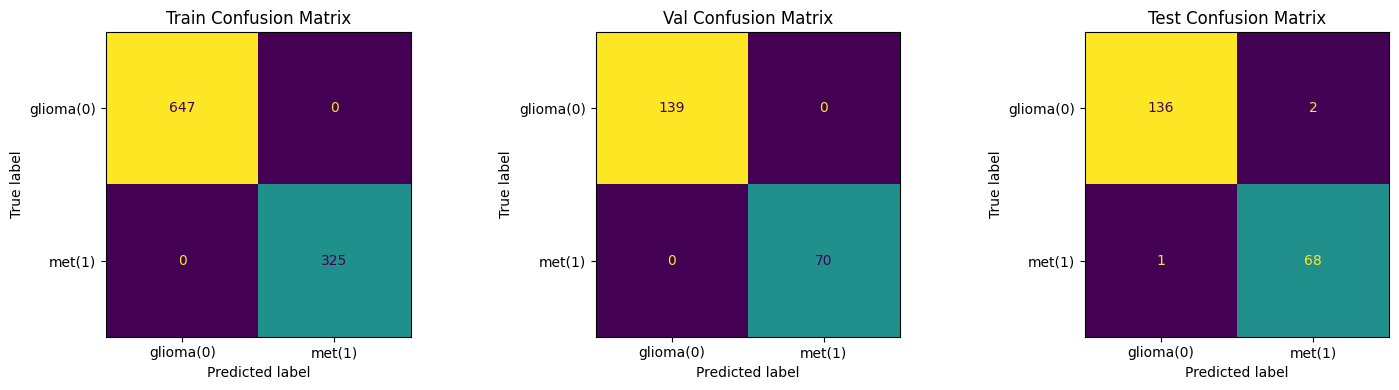

In [8]:
# Usage examples
print('RUN_DIR =', RUN_DIR)

# 1) Confusion matrices (Val/Test)
show_confusion_matrices()





Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In pytorch 2.9 this will be interpreted as tensor index, x[torch.tensor(seq)], which will result either in an error or a different result (Triggered internally at /pytorch/torch/csrc/autograd/python_variable_indexing.cpp:306.)
Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In pytorch 2.9 this will be interpreted as tensor index, x[torch.tensor(seq)], which will result either in an error or a different result (Triggered internally at /pytorch/torch/csrc/autograd/python_variable_indexing.cpp:306.)


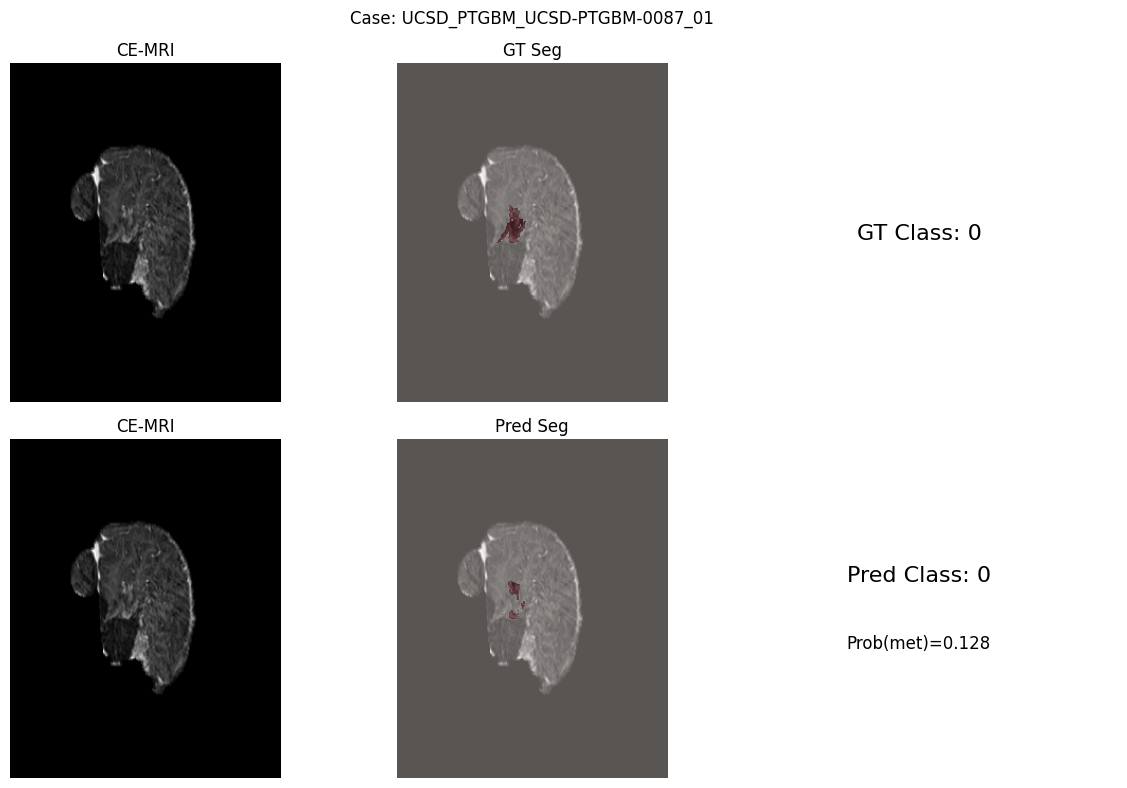

In [9]:
# 2) Random 2x3 example (Val)
show_random_case_grid(split='val')



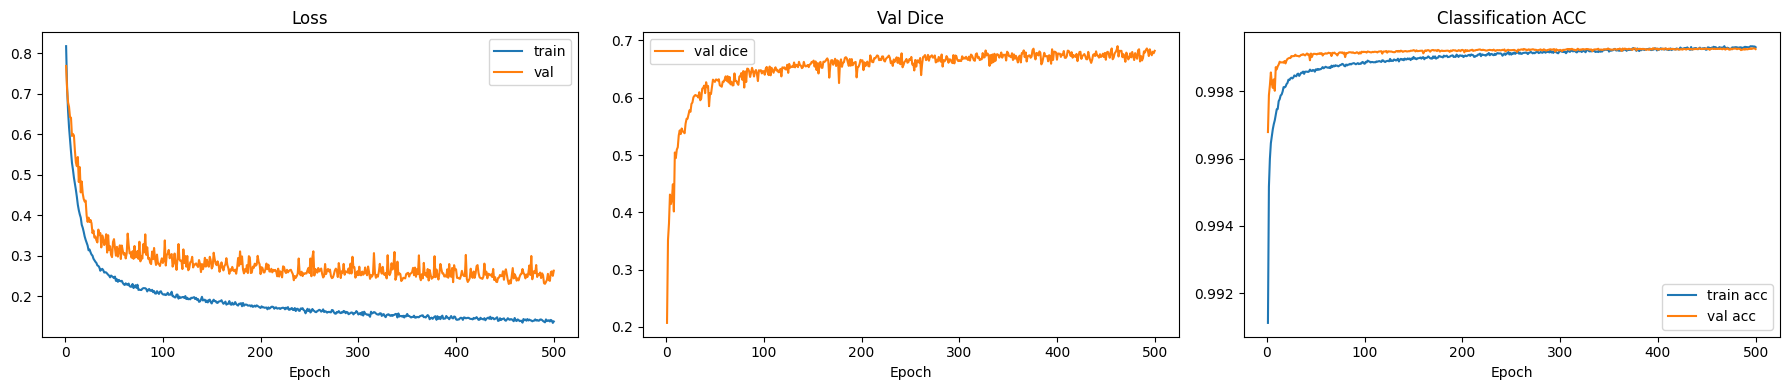

In [10]:
# 3) Training curves from metrics CSV
plot_training_curves(METRICS_CSV)



Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In pytorch 2.9 this will be interpreted as tensor index, x[torch.tensor(seq)], which will result either in an error or a different result (Triggered internally at /pytorch/torch/csrc/autograd/python_variable_indexing.cpp:306.)
Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In pytorch 2.9 this will be interpreted as tensor index, x[torch.tensor(seq)], which will result either in an error or a different result (Triggered internally at /pytorch/torch/csrc/autograd/python_variable_indexing.cpp:306.)


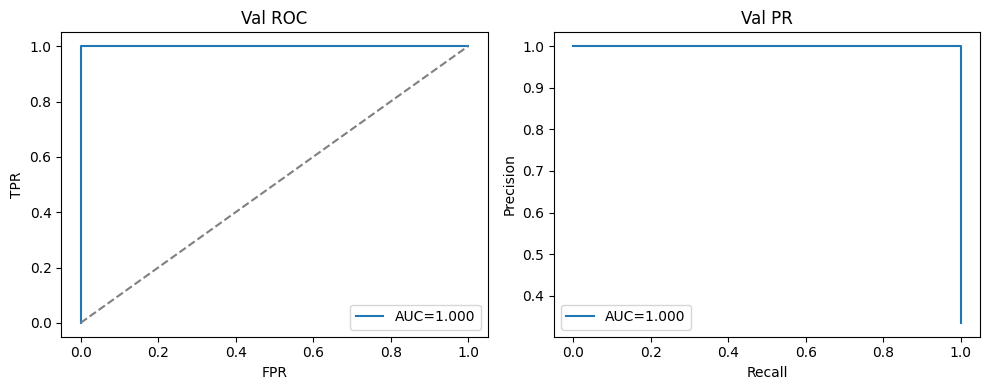

Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In pytorch 2.9 this will be interpreted as tensor index, x[torch.tensor(seq)], which will result either in an error or a different result (Triggered internally at /pytorch/torch/csrc/autograd/python_variable_indexing.cpp:306.)
Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In pytorch 2.9 this will be interpreted as tensor index, x[torch.tensor(seq)], which will result either in an error or a different result (Triggered internally at /pytorch/torch/csrc/autograd/python_variable_indexing.cpp:306.)


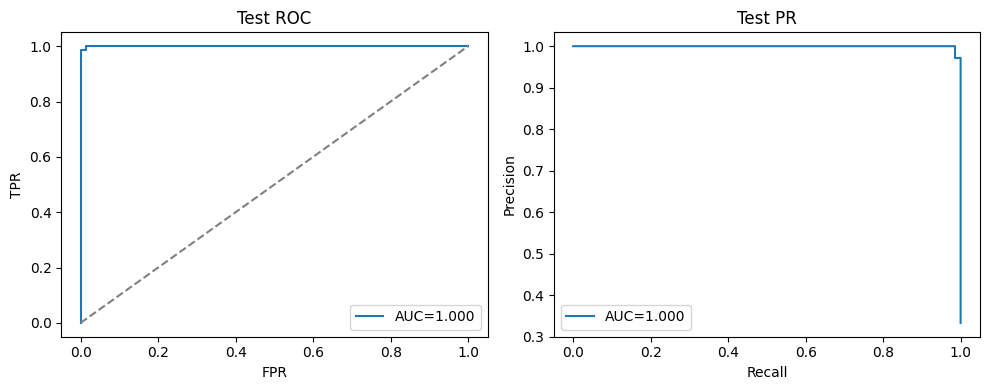

In [11]:
# 4) ROC/PR curves
plot_roc_pr_curves(val_loader, name='Val')
plot_roc_pr_curves(test_loader, name='Test')

In [ ]:
show_test_gallery(4)

Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In pytorch 2.9 this will be interpreted as tensor index, x[torch.tensor(seq)], which will result either in an error or a different result (Triggered internally at /pytorch/torch/csrc/autograd/python_variable_indexing.cpp:306.)
Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In pytorch 2.9 this will be interpreted as tensor index, x[torch.tensor(seq)], which will result either in an error or a different result (Triggered internally at /pytorch/torch/csrc/autograd/python_variable_indexing.cpp:306.)


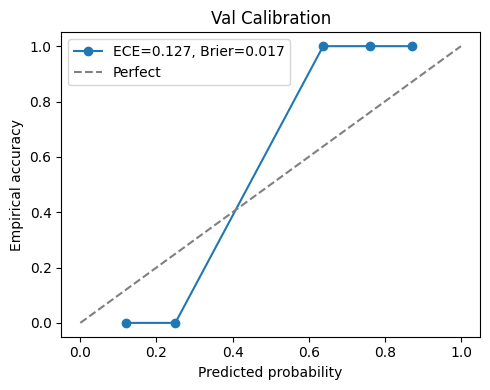

Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In pytorch 2.9 this will be interpreted as tensor index, x[torch.tensor(seq)], which will result either in an error or a different result (Triggered internally at /pytorch/torch/csrc/autograd/python_variable_indexing.cpp:306.)
Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In pytorch 2.9 this will be interpreted as tensor index, x[torch.tensor(seq)], which will result either in an error or a different result (Triggered internally at /pytorch/torch/csrc/autograd/python_variable_indexing.cpp:306.)


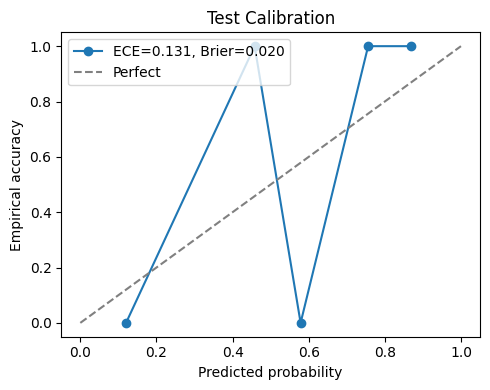

In [12]:
calibration_summary(val_loader, 'Val')
calibration_summary(test_loader, 'Test')